# Cryptocurrency Analytics

## Import Libraries

In [59]:
# Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import matplotlib.ticker as mticker
import seaborn as sns
import os
import networkx as nx
from pyvis import network as net
from urllib.request import Request, urlopen
from bs4 import BeautifulSoup as soup
import time
from IPython.display import display
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings("ignore")


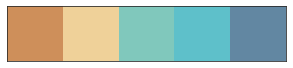

In [60]:
# Color palette
my_colors = ["#ce8f5a", "#efd199", "#80c8bc", "#5ec0ca", "#6287a2"]
sns.palplot(sns.color_palette(my_colors))

# Set Style. Inpired on https://www.kaggle.com/code/andradaolteanu/bitcoin-dogecoin-on-rapids-and-elon-musk
sns.set_style("white")
mpl.rcParams['xtick.labelsize'] = 14
mpl.rcParams['ytick.labelsize'] = 14
mpl.rcParams['axes.spines.left'] = False
mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

class color:
    BOLD = '\033[1m' + '\033[93m'
    END = '\033[0m'

## Listings

### Prepare Data

In [2]:
# Load data from balances
transactional_data=pd.read_csv('C:/Users/JCRG/Desktop/Master/Dissertation/Data/Transactional_Network_Ether.csv')
transactional_data.head()

,from_address,to_address,block_timestamp,value_ether
0,0x7ac34681f6aaeb691e150c43ee494177c0e2c183,0x7fb6fefe6c524d9cb06025583c0ad59aad2f6f5b,2018-07-11 11:57:20 UTC,1.00000
1,0xf1cf296c11d3b010e6dd3d48b6c5aaed613e96f1,0x2ec2c8729da460eb9743e86c3d16713f6aa47325,2018-07-11 01:53:49 UTC,3.04768
2,0x8e04af7f7c76daa9ab429b1340e0327b5b835748,0x0000000000085d4780b73119b644ae5ecd22b376,2019-08-20 14:27:26 UTC,0.00000
3,0x8f6147a13514d7cc7c1c85bc4fad8f7f1bc63b57,0x0d8775f648430679a709e98d2b0cb6250d2887ef,2019-05-30 03:04:18 UTC,0.00000
4,0x7b6f730249555a85d39327b90f0080e9dc63daff,0x1cb9ede1a43ab0265d6c44be4f3db554abf822c5,2019-05-30 13:17:56 UTC,250.00000


In [3]:
transactional_data

,from_address,to_address,block_timestamp,value_ether
0,0x7ac34681f6aaeb691e150c43ee494177c0e2c183,0x7fb6fefe6c524d9cb06025583c0ad59aad2f6f5b,2018-07-11 11:57:20 UTC,1.00000
1,0xf1cf296c11d3b010e6dd3d48b6c5aaed613e96f1,0x2ec2c8729da460eb9743e86c3d16713f6aa47325,2018-07-11 01:53:49 UTC,3.04768
2,0x8e04af7f7c76daa9ab429b1340e0327b5b835748,0x0000000000085d4780b73119b644ae5ecd22b376,2019-08-20 14:27:26 UTC,0.00000
3,0x8f6147a13514d7cc7c1c85bc4fad8f7f1bc63b57,0x0d8775f648430679a709e98d2b0cb6250d2887ef,2019-05-30 03:04:18 UTC,0.00000
4,0x7b6f730249555a85d39327b90f0080e9dc63daff,0x1cb9ede1a43ab0265d6c44be4f3db554abf822c5,2019-05-30 13:17:56 UTC,250.00000
...,...,...,...,...
7708063,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,2020-10-26 22:58:50 UTC,0.00000
7708064,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,2020-10-26 23:01:34 UTC,0.00000
7708065,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,2020-10-26 21:19:25 UTC,0.00000
7708066,0xffff46e05a09314daae9176fc32dba0f4172dcdb,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,2020-10-26 07:17:22 UTC,0.00000


### Define Functions to Generate Top 100 Tokens Used by Whales

In [4]:
# Get nametag with the addresses from Etherscan through crawler. This is perform to identify easier which are the names of the addresses, if available.
def get_nametag(address):
    #Make API request to Etherscan
    url = 'https://etherscan.io/address/%s'%(address) # Initiate with the first page of accounts with 100 records
    req = Request(url,headers={'User-Agent':'Mozilla/5.0 (X11; Linux x86_64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/47.0.2526.106 Safari/537.36'})   # Etherscan restricts the access for Webscrapping, reason why headers needs to be stated
    response = urlopen(req, timeout=500).read() # Read response
    page_soup = soup(response, "html.parser") # Parse HTML response
    page_soup.find('title')
    name=page_soup.find('title')
    name=str(name)
    name=((name.split('|')[0])[10:])[:-1]
    time.sleep(1) # Etherscan restricts the access if the requests are perform too fast. The function delays the code by two seconds
    return name

In [5]:
# This functions creates a dataframe with the addresses that have the greatest 'IN' degree in the network.
def network(transactional_data):
    # Prepare data for network. Group by sender and receiver and count the number of transactions
    network_data_grouped=transactional_data[['from_address','to_address','value_ether']].groupby(['from_address','to_address']).count()
    network_data_grouped.reset_index(inplace=True)
    network_data_grouped.sort_values(by=['value_ether'],ascending=False,inplace=True)
    # Create object with network data
    G = nx.from_pandas_edgelist(network_data_grouped,
                            source='from_address',
                            target='to_address',
                            create_using=nx.DiGraph)
    # Get the nodes where the whales are transacting with.
    df=pd.DataFrame(G.in_degree()).sort_values(1,ascending=False)
    df.columns=['Address','Count']
    # Select the top 100 addresses
    df=df[:200]
    # Create column with nametag
    df['tag'] = df['Address'].apply(get_nametag)
    return df

df=network(transactional_data)
df.head()

,Address,Count,tag
1,0xdac17f958d2ee523a2206206994597c13d831ec7,1166,Tether: USDT Stablecoin
4,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,992,Centre: USD Coin
66,0x6b175474e89094c44da98b954eedeac495271d0f,550,Maker: Dai Stablecoin
81,0xd26114cd6ee289accf82350c8d8487fedb8a0c07,532,OMG Network: OMG Token
39,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,458,Uniswap V2: Router 2


###  Merge Listing Dates to Get Address of Tokens

In [8]:
# Import Listings from Binance
listings=pd.read_csv('Listing_Dates.csv')
listings=df.merge(listings,on='tag',how='left')
listings.columns=['to_address','count','tag','listing_date']
listings[(listings['listing_date']!='Not listed')&(~listings['listing_date'].isna())]
listings.drop(['count'],axis=1,inplace=True)
listings.rename(columns={'to_address':'token_address'},inplace=True)
listings.head()

,token_address,tag,listing_date
0,0xdac17f958d2ee523a2206206994597c13d831ec7,Tether: USDT Stablecoin,NaN
1,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,Centre: USD Coin,NaN
2,0x6b175474e89094c44da98b954eedeac495271d0f,Maker: Dai Stablecoin,NaN
3,0xd26114cd6ee289accf82350c8d8487fedb8a0c07,OMG Network: OMG Token,Not listed
4,0x7a250d5630b4cf539739df2c5dacb4c659f2488d,Uniswap V2: Router 2,NaN


## Insider Trading

In [9]:
# Load data from balances
tokens_purchase=pd.read_csv('C:/Users/JCRG/Desktop/Master/Dissertation/Data/Tokens_Transactions_Purchase.csv')

In [423]:
# This functions creates a dataframe with the transactions that could have been done by insider trading.
# Merge data with the transactional data from addresses and filter out the addresses that are not in the listings
df2=tokens_purchase.merge(listings,on='token_address')
df2=df2[(df2['listing_date']!='Not listed')&(~df2['listing_date'].isna())]

# Configure time format for listing date
df2['listing_date']=pd.to_datetime(df2['listing_date'],infer_datetime_format=True)
# Configure time format for block_timestamp date
df2['block_timestamp_complete']=pd.to_datetime(df2['block_timestamp'],infer_datetime_format=True)
df2['block_timestamp']=df2['block_timestamp_complete'].dt.date
df2['block_timestamp']=pd.to_datetime(df2['block_timestamp'],infer_datetime_format=True)


# Create column with True & False for the difference between the listing date and the block timestamp. This are the transactions that has been done before 7 days of the listing in Binance.
df2['date_before_listing']=(df2['block_timestamp'] < (df2['listing_date']-timedelta(days=7)))

# Create column with True & False for transactions that has been done between the two stated dates, which are between the listing date and 30 days before it.
df2['date_between_listing']=(df2['block_timestamp'] > (df2['listing_date']-timedelta(days=7))) & (df2['block_timestamp'] < df2['listing_date'])

# Create column with key of address and tag for future filtering
df2['key']=df2[['to_address','tag']].agg('-'.join,axis=1)

# Create dataframe with 'from_address' and 'to_address' to filter 'from_address' that have had transactions 30 days before the listing in Binance.
previous_transactions_true=df2[(df2['date_before_listing']==True)].groupby(['to_address','tag']).nunique().reset_index()
previous_transactions_true=previous_transactions_true[['to_address','tag']]
# Create column with key of address and tag for future filtering
previous_transactions_true['key']=previous_transactions_true[['to_address','tag']].agg('-'.join,axis=1)

# Create dataframe with filter of transactional data and listings
df3 = df2[~df2.key.isin(list(previous_transactions_true['key']))]
df_insider_trading_before=df3[df3['date_between_listing']==True]

df_insider_trading_before
#pd.DataFrame(df_insider_trading_before['to_address'].unique()).to_csv('Tokens_Addresses.csv',index=False,header=False)

,token_address,from_address,to_address,value,block_timestamp,transaction_hash,tag,listing_date,block_timestamp_complete,date_before_listing,date_between_listing,key
7401,0x607f4c5bb672230e8672085532f7e901544a7375,0x564286362092d8e7936f0549571a803b203aaced,0xb47f2e40da0e388e1a8776334ec72924541cb268,4672802133000,2019-11-12,0x52e91f6645fd6c70f7c7a0a3cddeb7fbeed03c29b602...,RLC Token,2019-11-14,2019-11-12 02:58:54+00:00,False,True,0xb47f2e40da0e388e1a8776334ec72924541cb268-RLC...
26405,0x0d8775f648430679a709e98d2b0cb6250d2887ef,0xa910f92acdaf488fa6ef02174fb86208ad7722ba,0x6646ebd1a61f417410effe187e4ad1d6625e6c52,5021092511850000000000,2019-02-28,0x586c0b60992702609b16738a2e52632329b03b55213f...,Basic Attention: BAT Token,2019-03-04,2019-02-28 18:51:38+00:00,False,True,0x6646ebd1a61f417410effe187e4ad1d6625e6c52-Bas...
89457,0xe41d2489571d322189246dafa5ebde1f4699f498,0x1cd8dc2028df3b59b5d26f1a461cdf00cedf2dc8,0x7c759fd8deac7b6009cbcfa58c8d2705886596f4,10000000000000000000,2019-02-22,0xb4c1805f4b32e381edb0937e63e3ce69b242a8b9f5e5...,0x: ZRX Token,2019-02-28,2019-02-22 22:41:11+00:00,False,True,0x7c759fd8deac7b6009cbcfa58c8d2705886596f4-0x:...
89458,0xe41d2489571d322189246dafa5ebde1f4699f498,0x1cd8dc2028df3b59b5d26f1a461cdf00cedf2dc8,0x7c759fd8deac7b6009cbcfa58c8d2705886596f4,10000000000000000000,2019-02-22,0x0ef7707b64cad45f97c71fefe6dd4bb21428a4bc7c2d...,0x: ZRX Token,2019-02-28,2019-02-22 22:50:49+00:00,False,True,0x7c759fd8deac7b6009cbcfa58c8d2705886596f4-0x:...
89459,0xe41d2489571d322189246dafa5ebde1f4699f498,0x1cd8dc2028df3b59b5d26f1a461cdf00cedf2dc8,0x7c759fd8deac7b6009cbcfa58c8d2705886596f4,27800000000000000000000,2019-02-22,0x1a4470283b728a3a2df86a6b8b76f8999098dba37720...,0x: ZRX Token,2019-02-28,2019-02-22 23:09:51+00:00,False,True,0x7c759fd8deac7b6009cbcfa58c8d2705886596f4-0x:...
...,...,...,...,...,...,...,...,...,...,...,...,...
2034763,0x92d6c1e31e14520e676a687f0a93788b716beff5,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0x22fa8cc33a42320385cbd3690ed60a021891cb32,1365419536659893497543,2021-09-08,0xeab6341a2096499f405422af335d93560389f892b15d...,dYdX: DYDX Token,2021-09-10,2021-09-08 16:40:43+00:00,False,True,0x22fa8cc33a42320385cbd3690ed60a021891cb32-dYd...
2034764,0x92d6c1e31e14520e676a687f0a93788b716beff5,0x6c4ab1907805adcb0b7ae911a5d1b0b99d608b3c,0x4f96f50edb37a19216d87693e5db241e31bd3735,2865927606365459143362,2021-09-08,0xdf87be5e91da08db0ff349b8a324ea3a72780f44e652...,dYdX: DYDX Token,2021-09-10,2021-09-08 15:52:15+00:00,False,True,0x4f96f50edb37a19216d87693e5db241e31bd3735-dYd...
2034765,0x92d6c1e31e14520e676a687f0a93788b716beff5,0x00000092efe40470c25228372310142836f1eda6,0x03ae1a796dfe0400439211133d065bda774b9d3e,9990000000000000000,2021-09-08,0x097b9af5cdbf07af708b6aa181194993589e0f1b1950...,dYdX: DYDX Token,2021-09-10,2021-09-08 15:52:50+00:00,False,True,0x03ae1a796dfe0400439211133d065bda774b9d3e-dYd...
2034766,0x92d6c1e31e14520e676a687f0a93788b716beff5,0xc36442b4a4522e871399cd717abdd847ab11fe88,0x22fa8cc33a42320385cbd3690ed60a021891cb32,7079162723936576978777,2021-09-08,0x4c3d90ca5e8a45e70bf5861ee1c304260aff9be7595b...,dYdX: DYDX Token,2021-09-10,2021-09-08 19:32:56+00:00,False,True,0x22fa8cc33a42320385cbd3690ed60a021891cb32-dYd...


### Sales After Listing Date

In [212]:
# Load data from balances
token_data=pd.read_csv('C:/Users/JCRG/Desktop/Master/Dissertation/Data/Tokens_Transactional.csv')
token_data.head()

,token_address,from_address,to_address,value,block_timestamp,transaction_hash
0,0x5c40ef6f527f4fba68368774e6130ce6515123f2,0x599ad3f92f76e859f7b7a87dbe3aacb81e54c6e6,0x515f8cd6cdf5e26fab3068aac2fa2a1fd2aac4e7,14000000000000000000,2016-09-28 04:18:32 UTC,0x4a60a9368b1aa701c324286b384b0d790a15ab8a9d7d...
1,0x5c40ef6f527f4fba68368774e6130ce6515123f2,0x599ad3f92f76e859f7b7a87dbe3aacb81e54c6e6,0x755cdba6ae4f479f7164792b318b2a06c759833b,0,2016-09-28 04:28:49 UTC,0x72b41eff5671e02b7b8851f26e8ca3f1706896e3bca1...
2,0x5c40ef6f527f4fba68368774e6130ce6515123f2,0x599ad3f92f76e859f7b7a87dbe3aacb81e54c6e6,0x755cdba6ae4f479f7164792b318b2a06c759833b,0,2016-09-28 04:33:27 UTC,0x3d0125d50c288e58fb287a568a9e027ee49f264f9eff...
3,0xa74476443119a942de498590fe1f2454d7d4ac0d,0xeb3b9f824c8551a58a427aeaaa1044866bb5e28e,0x95969219968596a50b4a0ad09663a323376821a9,1000000000000000000000000,2017-04-17 12:42:48 UTC,0x04a217d04de3f2b0e7b42d2e59e673165f6ebd9fa265...
4,0xa74476443119a942de498590fe1f2454d7d4ac0d,0xeb3b9f824c8551a58a427aeaaa1044866bb5e28e,0x95969219968596a50b4a0ad09663a323376821a9,1000000000000000000000000,2017-05-29 13:01:39 UTC,0xae84fdf173036384965e2978ca4540a34eaf9780dcd6...


In [424]:
tokens=token_data.merge(listings,on='token_address')
tokens=tokens[(tokens['listing_date']!='Not listed')&(~tokens['listing_date'].isna())]

# Configure time format for listing date
tokens['listing_date']=pd.to_datetime(tokens['listing_date'],infer_datetime_format=True)
# Configure time format for block_timestamp date
tokens['block_timestamp_complete']=pd.to_datetime(tokens['block_timestamp'],infer_datetime_format=True)
tokens['block_timestamp']=tokens['block_timestamp_complete'].dt.date
tokens['block_timestamp']=pd.to_datetime(tokens['block_timestamp'],infer_datetime_format=True)

# Create column with True & False for transactions that has been done between the two stated dates, which are between the listing date and 30 days before it.
tokens['date_after_listing']= (tokens['block_timestamp'] > tokens['listing_date']) & (tokens['block_timestamp'] < (tokens['listing_date']+timedelta(days=7)))
tokens['key']=tokens[['from_address','tag']].agg('-'.join,axis=1)
tokens_complete=tokens.copy(deep=True)
# Create column with key of address and tag for future filtering
tokens=tokens[tokens['date_after_listing']==True]


df_insider_trading = df_insider_trading_before[df_insider_trading_before.key.isin(list(tokens['key']))]
df_insider_trading

,token_address,from_address,to_address,value,block_timestamp,transaction_hash,tag,listing_date,block_timestamp_complete,date_before_listing,date_between_listing,key
1361960,0xbbbbca6a901c926f240b89eacb641d8aec7aeafd,0x11111254369792b2ca5d084ab5eea397ca8fa48b,0x22fa8cc33a42320385cbd3690ed60a021891cb32,72763285533933631615967,2020-06-08,0x208d7b45ba777f5299272ef173687827fdb0e94359a2...,Loopring: LRC Token,2020-06-12,2020-06-08 19:32:22+00:00,False,True,0x22fa8cc33a42320385cbd3690ed60a021891cb32-Loo...
1457967,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xff629a3678a6f9bf79cd0ff2a38f4c9511e48355,0x8ff9c1e5b2b117267c41e1f4e3f75e7176c436c3,9366599932,2022-06-19,0x6f067be17a1c92d9945841a092357596d550347eb531...,Wrapped BTC: WBTC Token,2022-06-24,2022-06-19 07:07:55+00:00,False,True,0x8ff9c1e5b2b117267c41e1f4e3f75e7176c436c3-Wra...
1459734,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xff629a3678a6f9bf79cd0ff2a38f4c9511e48355,0x8ff9c1e5b2b117267c41e1f4e3f75e7176c436c3,1000000,2022-06-19,0x7108bd19e83a4c1910149a5f9472ad4340b3f75f8e8a...,Wrapped BTC: WBTC Token,2022-06-24,2022-06-19 06:58:43+00:00,False,True,0x8ff9c1e5b2b117267c41e1f4e3f75e7176c436c3-Wra...
1459739,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xc8034cd0b95655ea6dafbd8cd78bbe98f0b952ae,0x8ff9c1e5b2b117267c41e1f4e3f75e7176c436c3,1000000,2022-06-19,0xa47c06be271991686b425effccf2571d906aea4b6c24...,Wrapped BTC: WBTC Token,2022-06-24,2022-06-19 07:03:09+00:00,False,True,0x8ff9c1e5b2b117267c41e1f4e3f75e7176c436c3-Wra...
1459745,0x2260fac5e5542a773aa44fbcfedf7c193bc2c599,0xc8034cd0b95655ea6dafbd8cd78bbe98f0b952ae,0x8ff9c1e5b2b117267c41e1f4e3f75e7176c436c3,18329098264,2022-06-19,0x01fb5a04a9ba3255574dc3a4cbec36b4fefcacc0e227...,Wrapped BTC: WBTC Token,2022-06-24,2022-06-19 07:09:04+00:00,False,True,0x8ff9c1e5b2b117267c41e1f4e3f75e7176c436c3-Wra...
...,...,...,...,...,...,...,...,...,...,...,...,...
2034762,0x92d6c1e31e14520e676a687f0a93788b716beff5,0xc36442b4a4522e871399cd717abdd847ab11fe88,0x22fa8cc33a42320385cbd3690ed60a021891cb32,6071096310479285694870,2021-09-08,0x2875c5591978252b0030af0012e10540e5e354af5d29...,dYdX: DYDX Token,2021-09-10,2021-09-08 19:24:44+00:00,False,True,0x22fa8cc33a42320385cbd3690ed60a021891cb32-dYd...
2034763,0x92d6c1e31e14520e676a687f0a93788b716beff5,0x0000000000007f150bd6f54c40a34d7c3d5e9f56,0x22fa8cc33a42320385cbd3690ed60a021891cb32,1365419536659893497543,2021-09-08,0xeab6341a2096499f405422af335d93560389f892b15d...,dYdX: DYDX Token,2021-09-10,2021-09-08 16:40:43+00:00,False,True,0x22fa8cc33a42320385cbd3690ed60a021891cb32-dYd...
2034765,0x92d6c1e31e14520e676a687f0a93788b716beff5,0x00000092efe40470c25228372310142836f1eda6,0x03ae1a796dfe0400439211133d065bda774b9d3e,9990000000000000000,2021-09-08,0x097b9af5cdbf07af708b6aa181194993589e0f1b1950...,dYdX: DYDX Token,2021-09-10,2021-09-08 15:52:50+00:00,False,True,0x03ae1a796dfe0400439211133d065bda774b9d3e-dYd...
2034766,0x92d6c1e31e14520e676a687f0a93788b716beff5,0xc36442b4a4522e871399cd717abdd847ab11fe88,0x22fa8cc33a42320385cbd3690ed60a021891cb32,7079162723936576978777,2021-09-08,0x4c3d90ca5e8a45e70bf5861ee1c304260aff9be7595b...,dYdX: DYDX Token,2021-09-10,2021-09-08 19:32:56+00:00,False,True,0x22fa8cc33a42320385cbd3690ed60a021891cb32-dYd...


In [425]:
df_insider_trading['value']=(df_insider_trading['value'].astype(float))//1000000000000000000
tokens['value']=(tokens['value'].astype(float))/1000000000000000000

### Generate Results

#### Generate Suspicious Accounts

In [426]:
df_insider_trading_detail = df_insider_trading.groupby(['to_address','tag']).agg({'value':'sum','tag':'count'}).rename(columns={'value':'sum_value','tag':'tag_count'}).reset_index().sort_values(by=['tag_count'],ascending=False)
df_insider_trading_detail

,to_address,tag,sum_value,tag_count
67,0xcfc50541c3deaf725ce738ef87ace2ad778ba0c5,SushiSwap: SUSHI Token,456285.0,124
50,0x8bc110db7029197c3621bea8092ab1996d5dd7be,SushiSwap: SUSHI Token,25836.0,93
21,0x31a47094c6325d357c7331c621d6768ba041916e,SushiSwap: SUSHI Token,144488.0,65
40,0x6165fd87c1bc73a4c44b23934e9136fd92df5b01,SushiSwap: SUSHI Token,9211.0,62
38,0x600b8a34ec1cfd8b8af78cfc49708419a16ea2e8,SushiSwap: SUSHI Token,89894.0,41
...,...,...,...,...
29,0x49a2dcc237a65cc1f412ed47e0594602f6141936,SushiSwap: SUSHI Token,3192.0,1
23,0x33eecc48943aaeabb5328a25ff28eb85f67945c2,Curve.fi: CRV Token,88.0,1
27,0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0,Convex Finance: CVX Token,15285.0,1
63,0xb87f5110f19a42058908343ee10e5337a2b11187,Convex Finance: CVX Token,431.0,1


In [427]:
df_insider_trading_detail['key']=df_insider_trading_detail[['to_address','tag']].agg('-'.join,axis=1)
df_insider_trading_add_token=df_insider_trading_detail['key'].drop_duplicates()
df_insider_trading_add_token

67    0xcfc50541c3deaf725ce738ef87ace2ad778ba0c5-Sus...
50    0x8bc110db7029197c3621bea8092ab1996d5dd7be-Sus...
21    0x31a47094c6325d357c7331c621d6768ba041916e-Sus...
40    0x6165fd87c1bc73a4c44b23934e9136fd92df5b01-Sus...
38    0x600b8a34ec1cfd8b8af78cfc49708419a16ea2e8-Sus...
                            ...                        
29    0x49a2dcc237a65cc1f412ed47e0594602f6141936-Sus...
23    0x33eecc48943aaeabb5328a25ff28eb85f67945c2-Cur...
27    0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0-Con...
63    0xb87f5110f19a42058908343ee10e5337a2b11187-Con...
64    0xc25dc289edce5227cf15d42539824509e826b54d-dYd...
Name: key, Length: 88, dtype: object

In [428]:
df_insider_trading_addresses=pd.DataFrame(df_insider_trading.groupby(['to_address']).tag.value_counts().groupby(level=0).count().sort_values(ascending=False))
#df_insider_trading_addresses=df_insider_trading_addresses[df_insider_trading_addresses['tag']>1]
df_insider_trading_addresses

,tag
to_address,
0x22fa8cc33a42320385cbd3690ed60a021891cb32,4
0x8e04af7f7c76daa9ab429b1340e0327b5b835748,3
0x31a47094c6325d357c7331c621d6768ba041916e,2
0x8bc110db7029197c3621bea8092ab1996d5dd7be,2
0xa0f75491720835b36edc92d06ddc468d201e9b73,2
...,...
0x665d2d2444f2384fb3d96aaa0ea3536b92984dce,1
0x70265950add51748aa041de8accce6747507adce,1
0x82bdff92b259d83382c28a2d0cf3229e0d8b0b98,1


#### Focused Results- Representative Wallet

In [432]:
df2['value']=(df2['value'].astype(float))//1000000000000000000
tokens_complete['value']=(tokens_complete['value'].astype(float))/1000000000000000000

In [429]:
df_insider_trading_detail[df_insider_trading_detail['to_address']=='0x187e3534f461d7c59a7d6899a983a5305b48f93f']

,to_address,tag,sum_value,tag_count,key
12,0x187e3534f461d7c59a7d6899a983a5305b48f93f,Balancer: BAL Token,1688.0,2,0x187e3534f461d7c59a7d6899a983a5305b48f93f-Bal...


#### XXXX

In [309]:
tokens

,token_address,from_address,to_address,value,block_timestamp,transaction_hash,tag,listing_date,block_timestamp_complete,date_after_listing,key
6459,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,0x4ef377462b03b650d52140c482394a6703d0d338,0x4eda3df07254801def1ab3ebe50d79f5a6f3bfd6,40000.000000,2020-02-11,0x19136f7f3226cdc1b2450f9521a2f9b827bd087f490a...,Bancor: BNT Token,2020-02-06,2020-02-11 16:17:40+00:00,True,0x4ef377462b03b650d52140c482394a6703d0d338-Ban...
6460,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,0x4ef377462b03b650d52140c482394a6703d0d338,0x3ab6564d5c214bc416ee8421e05219960504eead,10000.000000,2020-02-11,0x494cf5915213939d592ee795477fbdba52ae43c30cb5...,Bancor: BNT Token,2020-02-06,2020-02-11 15:34:48+00:00,True,0x4ef377462b03b650d52140c482394a6703d0d338-Ban...
6461,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,0x4ef377462b03b650d52140c482394a6703d0d338,0x3ab6564d5c214bc416ee8421e05219960504eead,20000.000000,2020-02-11,0xe216d13c32f2f57b474b2c81ff5c5d185113e022932b...,Bancor: BNT Token,2020-02-06,2020-02-11 19:44:03+00:00,True,0x4ef377462b03b650d52140c482394a6703d0d338-Ban...
7541,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,0x4ef377462b03b650d52140c482394a6703d0d338,0x3ab6564d5c214bc416ee8421e05219960504eead,13500.000000,2020-02-11,0x02d47d6f0f067144a459f9bf41c286bce4dab7f79b4f...,Bancor: BNT Token,2020-02-06,2020-02-11 16:28:24+00:00,True,0x4ef377462b03b650d52140c482394a6703d0d338-Ban...
7542,0x1f573d6fb3f13d689ff844b4ce37794d79a7ff1c,0x4ef377462b03b650d52140c482394a6703d0d338,0x3ab6564d5c214bc416ee8421e05219960504eead,12000.000000,2020-02-11,0x58b02df16a86320836321182b47e26b339a3bd1c3c95...,Bancor: BNT Token,2020-02-06,2020-02-11 12:50:32+00:00,True,0x4ef377462b03b650d52140c482394a6703d0d338-Ban...
...,...,...,...,...,...,...,...,...,...,...,...
499897,0xc18360217d8f7ab5e7c516566761ea12ce7f9d72,0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa,0xe12b411bfee16a195cfa3802cf698d7cdb41b9dc,121.026543,2021-11-15,0x32da28d7dcb8700f91ee76b79e5a972e88caa7f0e614...,ENS: ENS Token,2021-11-10,2021-11-15 16:33:14+00:00,True,0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa-ENS...
499898,0xc18360217d8f7ab5e7c516566761ea12ce7f9d72,0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa,0xfda3ee277613afe269fe19b2b34b3ad62c2db663,99.290293,2021-11-15,0x9073c4e4415460f8f197619960fa2114430dc9b63b30...,ENS: ENS Token,2021-11-10,2021-11-15 09:03:53+00:00,True,0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa-ENS...
499899,0xc18360217d8f7ab5e7c516566761ea12ce7f9d72,0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa,0x4aaaf9be69e641b62049b50355ca2fab6e41e4b9,4.075210,2021-11-13,0xec73e48a0d04a4cfff7e29aa0e46d491ef9563d2d0c2...,ENS: ENS Token,2021-11-10,2021-11-13 10:32:48+00:00,True,0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa-ENS...
499900,0xc18360217d8f7ab5e7c516566761ea12ce7f9d72,0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa,0x09dbc431406459fe38f823c43b95b9ccec0c268c,2230.019533,2021-11-13,0xc8622daf412d08f4524772d3c7363f7d441e88667fbc...,ENS: ENS Token,2021-11-10,2021-11-13 01:31:05+00:00,True,0xf5f3436a05b5ced2490dae07b86eb5bbd02782aa-ENS...


In [430]:
# Print a df with the tokens with more addresses in insider trading timeframe
df_coins_insider_trading=pd.DataFrame(df_insider_trading
                                        .merge(df_insider_trading_addresses,on='to_address',how='left')
                                        .groupby(['to_address']).tag_x.value_counts()
                                        .groupby(level=1)
                                        .count()
                                        .sort_values(ascending=False)
                                        ).rename(columns={'tag_x':'count'}).reset_index()
df_coins_insider_trading

,tag_x,count
0,Curve.fi: CRV Token,32
1,SushiSwap: SUSHI Token,30
2,ENS: ENS Token,7
3,dYdX: DYDX Token,7
4,Shiba Inu: SHIB Token,3
5,Convex Finance: CVX Token,2
6,Aave: AAVE Token,1
7,Abracadabra.money: SPELL Token,1
8,Apecoin: APE Token,1
9,Balancer: BAL Token,1


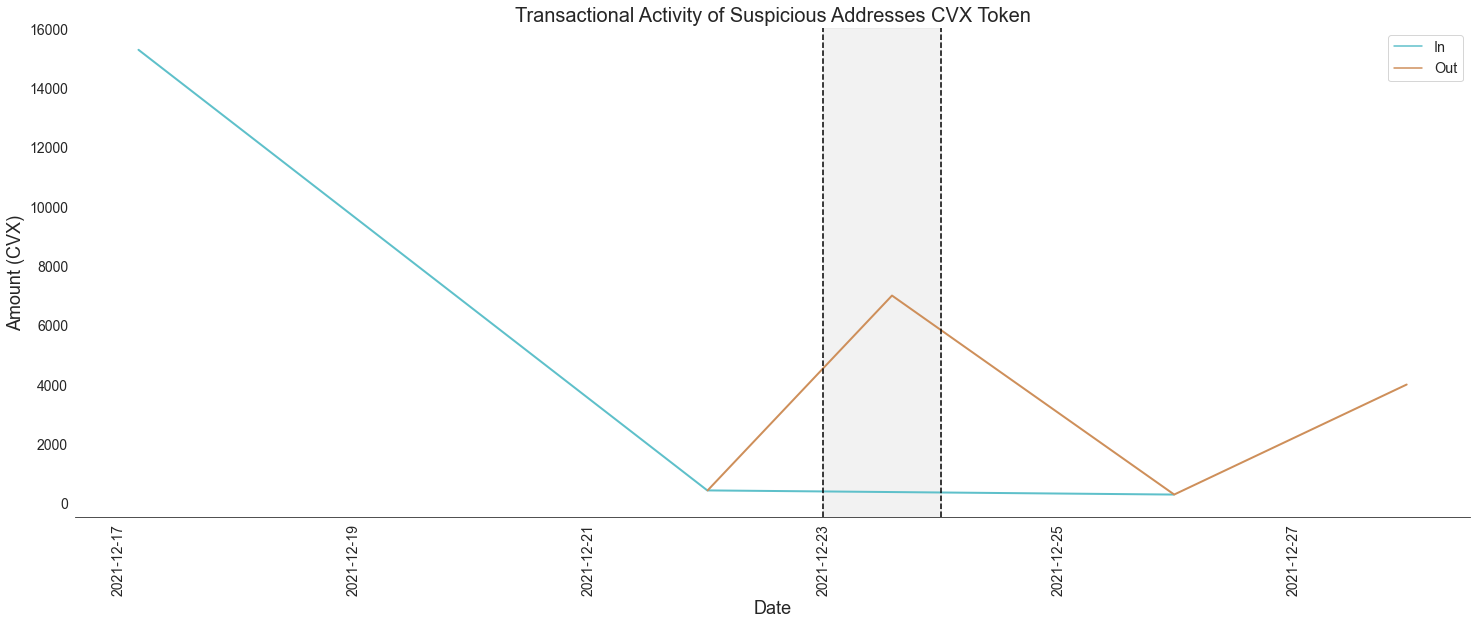

In [503]:

tok=df_coins_insider_trading['tag_x'][5]
list_date=listings[listings['tag']==tok]['listing_date'].min()

a=df2[(df2['tag']==tok)&(df2['key'].isin(list(df_insider_trading_add_token)))]
a=a.groupby(['block_timestamp_complete']).agg({'value':'sum'}).reset_index().sort_values(by=['value'],ascending=False)
a['type']='In'


b=tokens_complete[(tokens_complete['tag']==tok)&(tokens_complete['key'].isin(list(df_insider_trading_add_token)))]
b=b.groupby(['block_timestamp_complete']).agg({'value':'sum'}).reset_index().sort_values(by=['block_timestamp_complete'],ascending=False)
b['type']='Out'

c=a.merge(b,on=['block_timestamp_complete','type','value'],how='outer')

c=c[c['block_timestamp_complete'].dt.date<pd.to_datetime(list_date)+timedelta(days=7)]

# Plot
plt.figure(figsize=(25, 9))
ax = sns.lineplot(data=c, x="block_timestamp_complete", y="value", lw=2,hue='type',palette=[my_colors[3],my_colors[0]],legend=True)
plt.title("Transactional Activity of Suspicious Addresses CVX Token", size=20)
plt.xlabel("Date", size=18)
plt.ylabel("Amount (CVX)", size=18)
plt.xticks(rotation=90)
sns.despine(left=True)
plt.axvline(x=pd.to_datetime(list_date), color='black', linestyle='--')
plt.axvline(x=(pd.to_datetime(list_date)+timedelta(days=1)), color='black', linestyle='--')
ax.axvspan(pd.to_datetime(list_date), pd.to_datetime(list_date)+timedelta(days=1), alpha=0.1, color='grey')
plt.legend(fontsize=20) # using a size in points
plt.legend(fontsize="x-large") # using a named size
#ax.set_yscale('log')
plt.show()


#### Before Listing Data

In [504]:
df_insider_trading[df_insider_trading['tag']==tok].groupby(['to_address']).agg({'value':['sum','count','mean','min','max']}).sort_values(by=[('value','sum')],ascending=False)

value                          \
                                                sum count     mean      min   
to_address                                                                    
0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0  15285.0     1  15285.0  15285.0   
0xb87f5110f19a42058908343ee10e5337a2b11187    431.0     1    431.0    431.0   

                                                     
                                                max  
to_address                                           
0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0  15285.0  
0xb87f5110f19a42058908343ee10e5337a2b11187    431.0

In [ ]:
df_insider_trading[df_insider_trading['tag']==tok].sort_values(by=['value','block_timestamp_complete'],ascending=False)['transaction_hash'].values[0]

In [521]:
df_insider_trading[(df_insider_trading['tag']==tok)&(df_insider_trading['to_address']=='0xb87f5110f19a42058908343ee10e5337a2b11187')].sort_values(by=['block_timestamp_complete','value'],ascending=True)

,token_address,from_address,to_address,value,block_timestamp,transaction_hash,tag,listing_date,block_timestamp_complete,date_before_listing,date_between_listing,key
1991601,0x4e3fbd56cd56c3e72c1403e103b45db9da5b9d2b,0x0000000000000000000000000000000000000000,0xb87f5110f19a42058908343ee10e5337a2b11187,431.0,2021-12-22,0x2a234d3424e77f94cbee16fc835bcb9ddb31f6035d0b...,Convex Finance: CVX Token,2021-12-23,2021-12-22 00:17:10+00:00,False,True,0xb87f5110f19a42058908343ee10e5337a2b11187-Con...


#### After Listing Data

In [523]:
b=tokens_complete[(tokens_complete['tag']==tok)&(tokens_complete['from_address'].isin(list(df_insider_trading_addresses.reset_index()['to_address'])))]
b.groupby(['block_timestamp_complete','from_address']).agg({'value':'sum'}).reset_index().sort_values(by=['value'],ascending=False)
b[(b['from_address']=='0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0')&(tokens_complete['date_after_listing']==True)]

,token_address,from_address,to_address,value,block_timestamp,transaction_hash,tag,listing_date,block_timestamp_complete,date_after_listing,key
486731,0x4e3fbd56cd56c3e72c1403e103b45db9da5b9d2b,0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0,0x220bda5c8994804ac96ebe4df184d25e5c2196d4,4000.0,2021-12-27,0xb174f66b7378cdf7993510e291f2c05caf6f1c8c2c2d...,Convex Finance: CVX Token,2021-12-23,2021-12-27 23:11:38+00:00,True,0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0-Con...


In [519]:
b[(tokens_complete['date_after_listing']==True)&(tokens_complete['key'].isin(list(df_insider_trading_add_token)))].groupby(['from_address']).agg({'value':['sum','count','mean','min','max']}).sort_values(by=[('value','sum')],ascending=False)

value                     \
                                                    sum count         mean   
from_address                                                                 
0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0  4000.000000     1  4000.000000   
0xb87f5110f19a42058908343ee10e5337a2b11187   291.507613     1   291.507613   

                                                                      
                                                    min          max  
from_address                                                          
0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0  4000.000000  4000.000000  
0xb87f5110f19a42058908343ee10e5337a2b11187   291.507613   291.507613

In [522]:
b[(b['from_address']=='0x475a64058bcba94e5cfa7b76dbc49eaadf73d0f0')&(tokens_complete['date_after_listing']==True)]['transaction_hash'].values[0]

'0xb174f66b7378cdf7993510e291f2c05caf6f1c8c2c2dbb9ac9b5f1e880525ed4'

#### XXXX

In [ ]:
df_insider_trading.groupby(['to_address']).tag.value_counts().groupby(level=1).count().sort_values(ascending=False)

In [ ]:
# Print a df with the tokens with more addresses in insider trading timeframe
a=pd.DataFrame(df_insider_trading_addresses
                                        .merge(df_insider_trading,on='from_address',how='left'))
a

In [ ]:
b=pd.DataFrame(a.groupby(['from_address','block_timestamp']).tag_y.value_counts().sort_values(ascending=False)).rename(columns={'tag_y':'count'}).reset_index()
b[b['tag_y']=='Compound: Comptroller']

In [ ]:
b[b['tag_y']=='Curve.fi: CRV Token'].sort_values('block_timestamp')